In [4]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
% matplotlib inline
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from numpy.linalg import inv
from numpy.random import *

In [50]:
data = pd.read_csv("robust_norm_censored_4.csv")

In [13]:
# M市場についてしか観察できていいない時を考える。
# 実現した参入社数はnumからの経験分布からドロー
M = 10000
T = 1000
seed(1234)
m = data.shape[0]
draw = randint(1,T+1,m) 
data["draw"] = draw
data["realized_entry"] = data.apply(lambda x: 0 if(x["draw"] <= x["num0"]) else 1 if(x["draw"] <= x["num1"]) else 2, axis = 1)

In [54]:
data.head()

,Unnamed: 0,Dist1,Dist2,Pop,diff,num0,num1,num2,draw,realized_entry
0,0,0.628133,0.907969,2.706850,-0.895,2,101,897,816,2
1,3,0.528813,-0.589001,0.740122,-0.152,139,570,291,724,2
2,4,-0.758872,-0.933237,0.188695,-0.252,110,528,362,295,1
3,6,0.683509,0.302665,2.605967,-0.872,0,128,872,54,1
4,7,-1.706086,-1.159119,1.693723,-0.961,0,39,961,205,2


In [ ]:
# polynomial logitのために多項式こうを用意する
# 2nd order
data["popdist1"] = data["Pop"] * data["Dist1"]
data["popdist2"]= data["Pop"] * data["Dist2"]
data["dist1dist2"]= data["Dist2"] * data["Dist1"]
data["pop_sq"] = data["Pop"]**2
data["dist1_sq"] = data["Dist1"]**2
data["dist2_sq"] = data["Dist2"]**2

In [61]:
# 3rd order
data["pop_tr"] = data["Pop"]**3
data["dist1_tr"] = data["Dist1"]**3
data["dist2_tr"] = data["Dist2"]**3
data["pop_sqdist1"] = data["Pop"]**2 * data["Dist1"]
data["pop_sqdist2"] = data["Pop"]**2 * data["Dist2"]
data["dist1_sqpop"] = data["Pop"] * data["Dist1"]**2
data["dist1_sqdist2"] = data["Dist2"] * data["Dist1"]**2
data["dist2_sqpop"] = data["Pop"] * data["Dist2"]**2
data["dist2_sqdist1"] = data["Dist1"] * data["Dist2"]**2

,Unnamed: 0,Dist1,Dist2,Pop,diff,num0,num1,num2,draw,realized_entry,...,dist2_sq,pop_tr,dist1_tr,dist2_tr,pop_sqdist1,pop_sqdist2,dist1_sqpop,dist1_sqdist2,dist2_sqpop,dist2_sqdist1
0,0,0.628133,0.907969,2.706850,-0.895,2,101,897,816,2,...,0.824409,19.833186,0.247830,0.748538,4.602351,6.652725,1.067989,0.358240,2.231550,0.517838
1,3,0.528813,-0.589001,0.740122,-0.152,139,570,291,724,2,...,0.346922,0.405425,0.147879,-0.204337,0.289674,-0.322643,0.206970,-0.164710,0.256764,0.183457
2,4,-0.758872,-0.933237,0.188695,-0.252,110,528,362,295,1,...,0.870932,0.006719,-0.437024,-0.812786,-0.027020,-0.033229,0.108667,-0.537439,0.164341,-0.660926
3,6,0.683509,0.302665,2.605967,-0.872,0,128,872,54,1,...,0.091606,17.697294,0.319325,0.027726,4.641754,2.055421,1.217467,0.141401,0.238723,0.062614
4,7,-1.706086,-1.159119,1.693723,-0.961,0,39,961,205,2,...,1.343558,4.858778,-4.965954,-1.557344,-4.894244,-3.325163,4.929969,-3.373883,2.275615,-2.292225


realized entryを使って予測する

In [55]:
from sklearn import linear_model

In [56]:
logreg = linear_model.LogisticRegression(C=1e5)

In [64]:
Y = data.realized_entry
X = data.drop(["Unnamed: 0", "diff", "num0", "num1", "num2", "draw"],axis = 1)
logreg.fit(X, Y)

LogisticRegression(C=100000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [67]:
data["diff_est"] = logreg.predict_proba(X)[:, 0] - logreg.predict_proba(X)[:, 2]

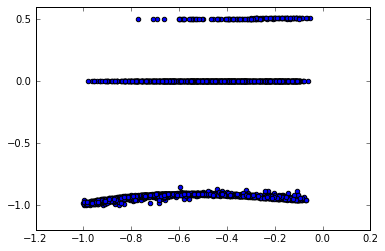

In [75]:
d = data["diff"].values
d_est = data["diff_est"].values
plt.scatter(d, d_est)

In [76]:
d_est

array([ -9.74528963e-01,  -9.50069371e-01,  -4.06091397e-05, ...,
        -9.15551596e-01,  -6.87662889e-06,  -9.94497430e-06])

In [77]:
logreg.score(X, Y)

1.0

d_estを使ってrobustを出してみる

In [80]:
import numdifftools as nd
def robust(x):
    xb1 = x[0] * pop + x[1] * dist1
    xb2 = x[0] * pop + x[1] * dist2
    r = (diff + s.cdf(xb1 + x[2])*s.cdf(xb2 + x[2]) - s.cdf(-xb1)*s.cdf(-xb2))**2
    return -sum(r)

def NR(initial, fun, tol, maxit):
    theta = initial
    for i in range(0,maxit):
        G = nd.Gradient(fun)(theta)
        H = nd.Hessian(fun)(theta)
        del_theta = inv(H).dot(G)
        theta = theta - del_theta
        if np.linalg.norm(del_theta) < tol:
            print("NR終わり")
            break
    return theta

s = st.norm()
pop = data[["Pop"]].values[:, 0]
dist1 = data[["Dist1"]].values[:, 0]
dist2 = data[["Dist2"]].values[:, 0]
diff = data[["diff_est"]].values[:, 0]
result_rob = NR([0.8,-0.5,-0.25], robust, 0.005, 10000)

NR終わり


In [81]:
result_rob

array([ 0.46537922, -0.31063035,  0.29986879])